In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import yfinance as yf

from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from sklearn.linear_model import LinearRegression

In [2]:
symbol = '^BVSP'
ibovespa = yf.Ticker(symbol)
historical_data = yf.download(symbol, period='5y')
historical_data

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-05-21,83095.0,83883.0,81576.0,81815.0,81815.0,4242200
2018-05-22,81817.0,83396.0,81613.0,82739.0,82739.0,4785500
2018-05-23,82742.0,82742.0,80867.0,80867.0,80867.0,3875500
2018-05-24,80860.0,80860.0,79027.0,80122.0,80122.0,6182200
2018-05-25,80123.0,80629.0,78622.0,78898.0,78898.0,4650100
...,...,...,...,...,...,...
2023-05-15,108469.0,109271.0,108356.0,109029.0,109029.0,11603200
2023-05-16,109029.0,110151.0,108085.0,108194.0,108194.0,16897300
2023-05-17,108194.0,109774.0,108188.0,109460.0,109460.0,13993000


In [3]:
n_lags = 3
for i in range(n_lags):
    historical_data[f'lag_{i+1}'] = historical_data['Close'].shift(i+1)
historical_data.dropna(inplace=True)
historical_data = historical_data[['lag_1', 'lag_2', 'lag_3', 'Close']]

In [4]:
cut = int(historical_data.shape[0]*0.8)  # Index onde vai ser splitado
cut_date = historical_data.index[cut]  # Data onde vai ser splitado

In [5]:
historical_data[historical_data.index <= cut_date].tail()

,lag_1,lag_2,lag_3,Close
Date,,,,
2022-05-18,108789.0,108233.0,106924.0,106247.0
2022-05-19,106247.0,108789.0,108233.0,107005.0
2022-05-20,107005.0,106247.0,108789.0,108488.0
2022-05-23,108488.0,107005.0,106247.0,110346.0
2022-05-24,110346.0,108488.0,107005.0,110581.0


In [6]:
historical_data[historical_data.index > cut_date].head()

,lag_1,lag_2,lag_3,Close
Date,,,,
2022-05-25,110581.0,110346.0,108488.0,110580.0
2022-05-26,110580.0,110581.0,110346.0,111890.0
2022-05-27,111890.0,110580.0,110581.0,111942.0
2022-05-30,111942.0,111890.0,110580.0,111032.0
2022-05-31,111032.0,111942.0,111890.0,111351.0


In [7]:
X_train = historical_data[historical_data.index <= cut_date].drop('Close', axis=1)
y_train = historical_data[historical_data.index <= cut_date]['Close']
X_test = historical_data[historical_data.index >= cut_date].drop('Close', axis=1)
y_test = historical_data[historical_data.index >= cut_date]['Close']

In [8]:
scaler = MinMaxScaler()
norm_X_train = scaler.fit_transform(X_train.values.reshape(-1,3))
norm_y_train = scaler.fit_transform(y_train.values.reshape(-1,1))
norm_X_test = scaler.fit_transform(X_test.values.reshape(-1,3))
norm_y_test = scaler.fit_transform(y_test.values.reshape(-1,1))

In [9]:
future_features = pd.date_range(start='2019-05-28', end='2023-05-19')

In [10]:
mlp_regressor = MLPRegressor(hidden_layer_sizes=(50, 50), max_iter=500, random_state=42, activation='tanh')
mlp_regressor.fit(norm_X_train, norm_y_train)
y_pred = mlp_regressor.predict(norm_X_test)

c:\Users\Gracinha\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [11]:
y_test_inv = scaler.inverse_transform(norm_y_test)
y_pred_inv = scaler.inverse_transform(y_pred.reshape(-1,1))

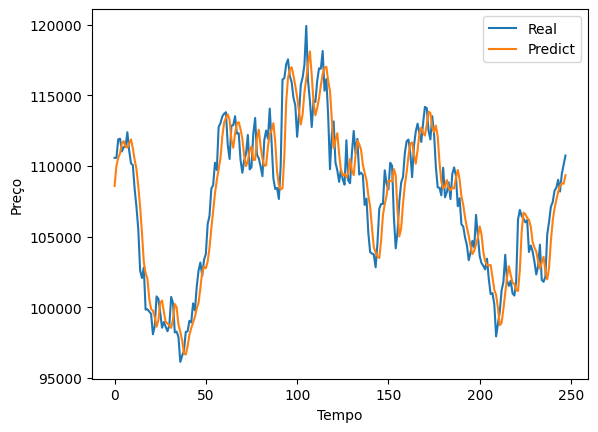

In [12]:
plt.plot(y_test.values, label='Real')
plt.plot(y_pred_inv, label='Predict')
plt.xlabel('Tempo')
plt.ylabel('Preço')
plt.legend()
plt.show()

In [14]:
results = pd.DataFrame({'Real': y_test.values, 'Predict': y_pred_inv.reshape(-1)})
results.head()

,Real,Predict
0,96567.0,95082.567929
1,97457.0,96243.020943
2,97030.0,96902.733268
3,97020.0,97329.503636
4,97380.0,97313.544957


In [15]:
print('RMSE: ', np.sqrt(mean_squared_error(results['Real'], results['Predict'])))
print('MAE: ', mean_absolute_error(results['Real'], results['Predict']))
print('MAPE: ', mean_absolute_percentage_error(results['Real'], results['Predict']))
print('R2: ', r2_score(results['Real'], results['Predict']))

RMSE:  2064.936931034105
MAE:  1521.042264622777
MAPE:  0.01464283906245078
R2:  0.9638149176142021


### Regressão linear de comparação

In [13]:
lr = LinearRegression()
lr.fit(X_train, y_train)
lr_pred = lr.predict(X_test)

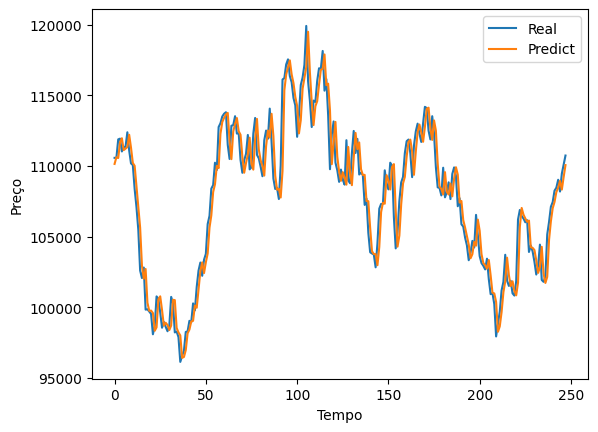

In [14]:
plt.plot(y_test.values, label='Real')
plt.plot(lr_pred, label='Predict')  
plt.xlabel('Tempo')
plt.ylabel('Preço')
plt.legend()
plt.show()

### Outra abordagem

In [15]:
n_steps = y_test.shape[0]
input_data = norm_X_test[-1]  # Use the last data point from the test set as input
predictions = []

for i in range(n_steps):
    prediction = mlp_regressor.predict(input_data.reshape(1, -1))
    predictions.append(prediction[0])
    input_data = np.roll(input_data, -1)
    input_data[-1] = prediction

predictions = np.array(predictions)
predictions = scaler.inverse_transform(predictions.reshape(-1,1))

In [16]:
predictions

array([[109351.37403449],
       [108818.98181451],
       [109034.86992573],
       [109053.43032904],
       [109057.97327418],
       [109115.89029314],
       [109136.3737099 ],
       [109173.31480974],
       [109205.77877465],
       [109237.84329175],
       [109270.97881163],
       [109303.18460113],
       [109335.64693935],
       [109367.90123711],
       [109400.03622492],
       [109432.08180473],
       [109463.99209747],
       [109495.79121333],
       [109527.46694526],
       [109559.01932533],
       [109590.44707223],
       [109621.74727755],
       [109652.91858495],
       [109683.95886187],
       [109714.86626752],
       [109745.63895391],
       [109776.27506125],
       [109806.77278772],
       [109837.13033933],
       [109867.34595401],
       [109897.41789577],
       [109927.3444552 ],
       [109957.12395173],
       [109986.75473312],
       [110016.23517663],
       [110045.56368949],
       [110074.73870947],
       [110103.75870555],
       [1101

In [17]:
y_test.shape

(248,)

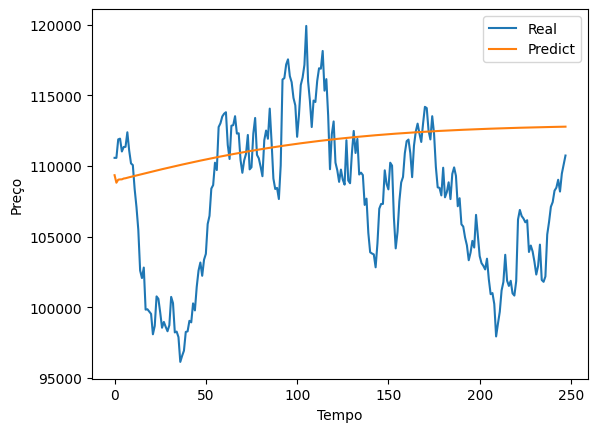

In [18]:
results = pd.DataFrame({'Real': y_test.values, 'Predict': predictions.reshape(-1)})
plt.plot(y_test.values, label='Real')
plt.plot(predictions, label='Predict')
plt.xlabel('Tempo')
plt.ylabel('Preço')
plt.legend()
plt.show()

In [19]:
# Ficou um lixo mas é um trabalho honesto